# Notebook on Featurization - Inorganic

By Dane Morgan with a lot of materials taken from

*   [Ben Afflerbach's course module 4](https://bafflerbach.github.io/test_software_carpentry/).
*   [Andrew Medford's course module 6](https://github.com/medford-group/data_analytics_ChE).
*  [MASTML Tutorials](https://github.com/uw-cmg/MAST-ML)
* Other stuff from the web...

Learning goal: To learn basic concepts about how materials systems are featurized and how optimal features are generated and selected.

## Getting started and hints
* Remember to click "Shift+Return" or click "Run" from the top bar to run each cell.
* You will need to set the correct value for the path variable.
* You may need to restart runtime during MAST-ML install. * You may need to restart runtime during MAST-ML install. After you do that please rerun the noteboook from the start to be sure all is loaded properly.


In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

# Summary of key ideas
* Featurizing from elemental properties
* Basic fit and train/test split with GPR.
* Exploration of (unsuccessful) feature optimization with PCA.
* Feature optimization (Forward selection on Random forest, SHAP, PCA)

# How to read this notebook
I would skip the setup sections and jump right to section
* Basic Full and Train/Test Splits Fits to Data
and go through that.  
Then I would look at
* Feature reduction with Random Forest.
Then the next two sections:
* Feature reduction with SHAP.
* Feature reduction with Forward Selection.
can be read quickly for now as they are very similar to Random Forest section. Then try to answer the problems which will bring you back to the above sections for guidance.

# Colab setup

Here, modify the path where you saved this notebook and the associated lab files on your Google drive, if different from below (this is an example Dane Morgan had for class)

In [2]:
#path = '/content/drive/MyDrive/Colab Stuff/MSE_803_Lab3_Dev_23/'
#path = '/content/drive/MyDrive/Online Filed/Dane Morgan Mixed Sharing/Projects/Courses/MSE803 F22/Module 3 Featurization/Lab Featurization/'

Check the path name is assigned correctly.

In [3]:
#!echo $path
#import os
#os.path.isdir(path)

In [4]:
# This is needed so can import packages from a different path than standard libraries
#import sys
#sys.path.append(path)
# get timings
import time

In [5]:
# Load MASTML and its dependencies
#!pip install mastml==3.1.5
#!pip install pyyaml==5.4.1
#!pip install mastml
#!pip install pyyaml

# Import data (pandas) and plotting to help with handling dataframes throughout the notebook.
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Import some MASTML modules
from mastml.mastml import Mastml
from mastml.datasets import LocalDatasets
from mastml.data_cleaning import DataCleaning
from mastml.preprocessing import SklearnPreprocessor
from mastml.models import SklearnModel
from mastml.data_splitters import SklearnDataSplitter, NoSplit
from mastml.feature_selectors import EnsembleModelFeatureSelector, NoSelect, SklearnFeatureSelector, MASTMLFeatureSelector
from mastml.feature_selectors import ShapFeatureSelector
from mastml.feature_generators import ElementalFeatureGenerator
from mastml.learning_curve import LearningCurve
from mastml.hyper_opt import GridSearch
from mastml.hyper_opt import GridSearch

Figshare is an optional dependency. To import data from figshare, manually install figshare via git clone of git clone https://github.com/cognoma/figshare.git
forestci is an optional dependency. To install latest forestci compatabilty with scikit-learn>=0.24, run pip install git+git://github.com/scikit-learn-contrib/forest-confidence-interval.git
XGBoost is an optional dependency. If you want to use XGBoost models, please manually install xgboost package with pip install xgboost. If have error with finding libxgboost.dylib library, dobrew install libomp. If do not have brew on your system, first do ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)" from the Terminal
scikit-lego is an optional dependency, enabling use of the LowessRegression model. If you want to use this model, do "pip install scikit-lego"


# Import diffusion data and featurize with elemental features

In [7]:
# Load scikit-learn (sklearn), a widely used package of ML routines
# don't need to do this on colab as it is already installed.
# Import some sklearn modules
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

In [8]:
# Load dataset
dataset = './resources/Dataset_diffusion_v1.xlsx'

# Pandas load
#dataset = pd.read_csv(filepath)

# MASTML load.
target = 'E_regression'
#extra_columns = ['Material compositions 1', 'Material compositions 2', 'Material compositions joined']
extra_columns = ['Material compositions 1','Material compositions 2','Material compositions joined']
d = LocalDatasets(file_path=dataset,
                  target=target,
                  extra_columns=extra_columns,
                  group_column='Material compositions 1',
                  testdata_columns=None,
                  as_frame=True)

# Load the data with the load_data() method
data_dict = d.load_data()

# Designate the X, y and X_extra data
X = data_dict['X']
y = data_dict['y']
X_extra = data_dict['X_extra']
groups = data_dict['groups']

# Set features and targets
#print('Targets y')
#y
print('Features X')
print(X)
print('X_extra')
print(X_extra)
#print('Groups groups')
#groups

Features X
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[408 rows x 0 columns]
X_extra
    Material compositions 1 Material compositions 2  \
0                        Ag                      Ag   
1                        Ag                      Co   
2                        Ag                      Cr   
3                        Ag                      Cu   
4                        Ag                      Fe   
..                      ...                     ...   
403                      Zr                      Nb   
404                      Zr                      Ta   
405                      Zr    

Here we update to use features generated here from elemental properties using MASTML. The evaluate() method conducts the feature generation and saves the output to a designated folder under the provided path. In this folder, the generated data is saved as the file generated_features.xlsx. Note that if you change this please rerun the cell above to reset X before rerunning this cell.

In [9]:
X, y = ElementalFeatureGenerator(composition_df=X_extra['Material compositions joined'],
                             # Long featurization (319 features)
#                                 feature_types=['composition_avg', 'max', 'min', 'difference'],
                             # Short featurization (83 features)
                                 feature_types=['composition_avg'],
                                 remove_constant_columns=True).evaluate(X=X, y=y, savepath='./resources/', make_new_dir=True)
print('New featurization X')
X.head(5)

Dropping 1/88 generated columns due to missing values
New featurization X


,AtomicNumber_composition_average,AtomicRadii_composition_average,AtomicVolume_composition_average,AtomicWeight_composition_average,BCCefflatcnt_composition_average,BCCenergy_pa_composition_average,BCCfermi_composition_average,BCCmagmom_composition_average,BCCvolume_pa_composition_average,BCCvolume_padiff_composition_average,...,SecondIonizationEnergy_composition_average,ShearModulus_composition_average,SpaceGroupNumber_composition_average,SpecificHeatCapacity_composition_average,ThermalConductivity_composition_average,ThermalExpansionCoefficient_composition_average,ThirdIonizationEnergy_composition_average,n_ws^third_composition_average,phi_composition_average,valence_composition_average
0,47.0,1.4440,17.075648,107.868200,6.375951,-2.719979,4.052760,0.000000,16.200,-0.1300,...,21.490,30.0,225.0,0.235,429.00,18.90,34.8300,1.360,4.350,2.0
1,37.0,1.3485,14.035754,83.400698,5.941635,-4.850033,5.096587,0.842019,13.320,0.0325,...,19.275,52.5,209.5,0.328,264.50,15.95,34.1650,1.555,4.725,2.5
2,35.5,1.3465,14.584293,79.932150,6.004376,-6.112393,6.014901,0.000000,13.685,-0.0750,...,18.995,72.5,227.0,0.342,261.35,11.90,32.8950,1.545,4.500,4.0
3,38.0,1.3610,14.452795,85.707100,5.996791,-3.181433,4.215750,0.000000,13.640,-0.0600,...,20.891,39.0,225.0,0.310,415.00,17.70,35.8300,1.415,4.400,2.0
4,36.5,1.3425,14.426506,81.856600,5.966899,-5.502732,5.252127,1.055331,13.465,-0.0650,...,18.835,56.0,227.0,0.342,254.60,15.35,32.7405,1.565,4.640,4.0


We now have a large number of features! It is unlikely that all of these features will be meaningful in whatever model we develop. Below we explore a few feature selection routines by selecting features for this full dataset.

# Basic Full and Train/Test Splits Fits to Data

First let's do a simple fit to the target data with these features using a common machine learning method called Gaussian Process Regression (GPR).

In [10]:
# Import modules
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, ConstantKernel

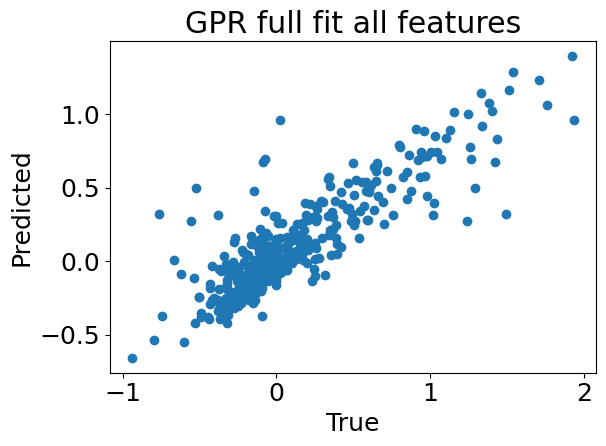

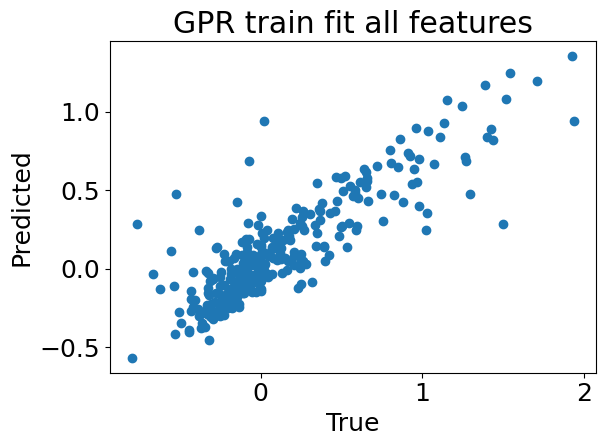

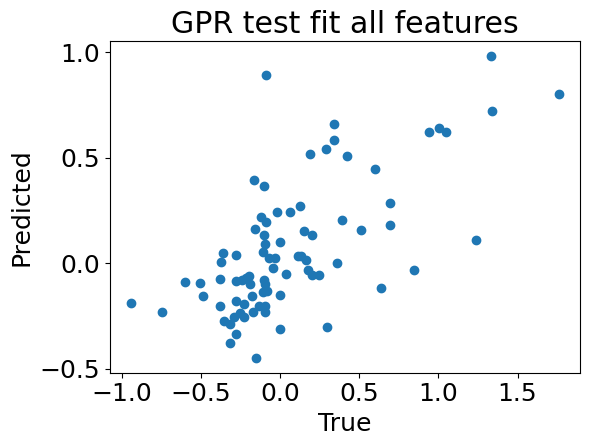

,AtomicNumber_composition_average,AtomicRadii_composition_average,AtomicVolume_composition_average,AtomicWeight_composition_average,BCCefflatcnt_composition_average,BCCenergy_pa_composition_average,BCCfermi_composition_average,BCCmagmom_composition_average,BCCvolume_pa_composition_average,BCCvolume_padiff_composition_average,...,SecondIonizationEnergy_composition_average,ShearModulus_composition_average,SpaceGroupNumber_composition_average,SpecificHeatCapacity_composition_average,ThermalConductivity_composition_average,ThermalExpansionCoefficient_composition_average,ThirdIonizationEnergy_composition_average,n_ws^third_composition_average,phi_composition_average,valence_composition_average
0,47.0,1.4440,17.075648,107.868200,6.375951,-2.719979,4.052760,0.000000,16.200,-0.1300,...,21.490,30.0,225.0,0.235,429.00,18.90,34.8300,1.360,4.350,2.0
1,37.0,1.3485,14.035754,83.400698,5.941635,-4.850033,5.096587,0.842019,13.320,0.0325,...,19.275,52.5,209.5,0.328,264.50,15.95,34.1650,1.555,4.725,2.5
2,35.5,1.3465,14.584293,79.932150,6.004376,-6.112393,6.014901,0.000000,13.685,-0.0750,...,18.995,72.5,227.0,0.342,261.35,11.90,32.8950,1.545,4.500,4.0
3,38.0,1.3610,14.452795,85.707100,5.996791,-3.181433,4.215750,0.000000,13.640,-0.0600,...,20.891,39.0,225.0,0.310,415.00,17.70,35.8300,1.415,4.400,2.0
4,36.5,1.3425,14.426506,81.856600,5.966899,-5.502732,5.252127,1.055331,13.465,-0.0650,...,18.835,56.0,227.0,0.342,254.60,15.35,32.7405,1.565,4.640,4.0


In [11]:
# Run fits
# kernel = ConstantKernel() * RBF() + WhiteKernel()
# kernel = ConstantKernel()*RBF()
kernel = ConstantKernel() * Matern() + WhiteKernel()

# Run a full fit to all data

# Normalize data which is key for GPR method
Xscaled=StandardScaler().fit_transform(X)

gpr = GaussianProcessRegressor(kernel=kernel,
                               n_restarts_optimizer=10,
                               ).fit(Xscaled, y)
ypred = gpr.predict(Xscaled, return_std=False)

# Plot results
xpl=y
ypl=ypred
plt.scatter(xpl,ypl,marker='o')
plt.title('GPR full fit all features')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# Run a fit with train/test split

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Scale data.  Define instance of class so it
# remembers scaling values for test data later.
scalar=StandardScaler()
X_train_scaled=scalar.fit_transform(X_train)

kernel = ConstantKernel() * Matern() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
                               n_restarts_optimizer=10,
                               ).fit(X_train_scaled, y_train)
y_train_pred = gpr.predict(X_train_scaled, return_std=False)

X_test_scaled=scalar.transform(X_test)
y_test_pred = gpr.predict(X_test_scaled, return_std=False)

# plot results
xpl=y_train
ypl=y_train_pred
plt.scatter(xpl,ypl,marker='o')
plt.title('GPR train fit all features')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# plot results
xpl=y_test
ypl=y_test_pred
plt.scatter(xpl,ypl,marker='o')
plt.title('GPR test fit all features')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()
X.head(5)

In [12]:
# RMSE on the train and test
from mastml.metrics import root_mean_squared_error
rmse_train=root_mean_squared_error(y_train_pred,y_train)
rmse_test=root_mean_squared_error(y_test_pred,y_test)
print("RMSE Train:", rmse_train, " RMSE Test", rmse_test)

RMSE Train: 0.24735214784462603  RMSE Test 0.35797684142581193


Notice that the test data predictions are not as good as train, as expected. Now let's try Principal Component Analysis (PCA) to reduce the feature set.

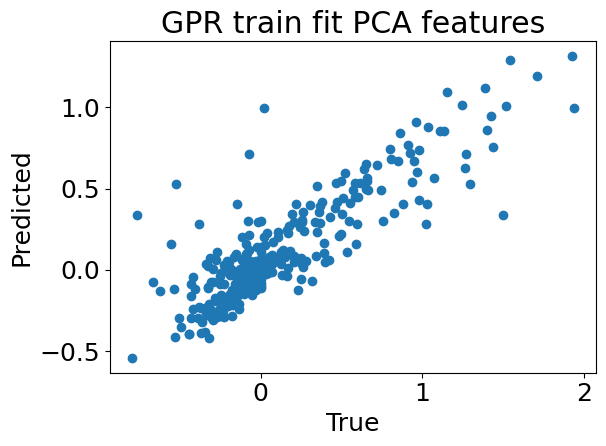

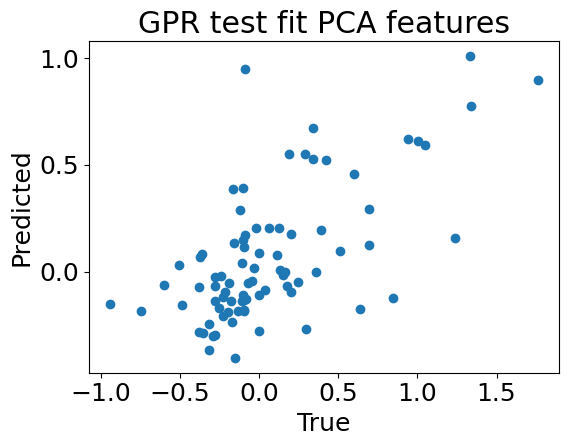

In [13]:
# Get PCA from SKLearn
ncomp=20
pca = PCA(n_components=ncomp)

# Run a fit with train/test split

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Scale data.  Define instance of class so it
# remembers scaling values for test data later.
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)

# Get PCA tranformed version of our original features
X_train_scaled_pca = pca.fit_transform(X_train_scaled)

kernel = ConstantKernel() * Matern() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
                               n_restarts_optimizer=10,
                               ).fit(X_train_scaled_pca, y_train)
y_train_pred = gpr.predict(X_train_scaled_pca, return_std=False)

# Get scaled PCA for test features. Note here we use "transform" to
# apply the fitted transforms from above.
X_test_scaled = scaler.transform(X_test)
X_test_scaled_pca = pca.transform(X_test_scaled)

# Predict test data
y_test_pred = gpr.predict(X_test_scaled_pca, return_std=False)

# plot results
xpl=y_train
ypl=y_train_pred
plt.scatter(xpl,ypl,marker='o')
plt.title('GPR train fit PCA features')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# plot results
xpl=y_test
ypl=y_test_pred
plt.scatter(xpl,ypl,marker='o')
plt.title('GPR test fit PCA features')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [14]:
# RMSE on the train and test
from mastml.metrics import root_mean_squared_error
rmse_train=root_mean_squared_error(y_train_pred,y_train)
rmse_test=root_mean_squared_error(y_test_pred,y_test)
print("RMSE Train:", rmse_train, " RMSE Test", rmse_test)

RMSE Train: 0.24976370349774346  RMSE Test 0.36547984321851584


This result above is about the same as with all the features, but now uses just 20 features.  So that is certainly much faster. It is potentially more accurate although we don't really see that here. It may be harder to interpret since the features have been changed. An alternative to avoid that issue is to use a method of feature reduction that does not change features, which we will explore below.

# Feature reduction with Random Forest.
Let's start by using the EnsembleModelFeatureSelector, which fits the data
using a random forest model, and selects features based on the resulting
random forest feature importance ranking.  We will keep the top 20 features.

In [15]:
model = SklearnModel(model='RandomForestRegressor')
selector = EnsembleModelFeatureSelector(model=model,
                                        n_features_to_select=20)
X_RF = selector.evaluate(X=X, y=y, savepath='./resources/', make_new_dir=False)
print('Features selected with Random Forest')
X_RF.head(5)

Features selected with Random Forest


,SpecificHeatCapacity_composition_average,BCCvolume_padiff_composition_average,MeltingT_composition_average,HeatVaporization_composition_average,IonicRadii_composition_average,HeatCapacityMass_composition_average,GSenergy_pa_composition_average,MendeleevNumber_composition_average,NdValence_composition_average,FirstIonizationEnergy_composition_average,BCCenergy_pa_composition_average,HHIr_composition_average,BoilingT_composition_average,HeatCapacityMolar_composition_average,ElasticModulus_composition_average,ElectronAffinity_composition_average,ThirdIonizationEnergy_composition_average,MiracleRadius_composition_average,HeatFusion_composition_average,ThermalExpansionCoefficient_composition_average
0,0.235,-0.1300,1234.930,250.630,1.150,0.235,-2.765394,65.0,10.0,7.576230,-2.719979,1400.0,2435.0,25.350,80.0,125.70,34.8300,144.0,11.300,18.90
1,0.328,0.0325,1501.465,311.965,0.900,0.328,-4.922891,61.5,8.5,7.728620,-4.850033,2050.0,2817.5,25.080,144.0,97.85,34.1650,134.5,13.750,15.95
2,0.342,-0.0750,1707.465,295.065,0.885,0.342,-6.135555,57.0,7.5,7.171370,-6.112393,2750.0,2689.5,24.350,169.5,94.85,32.8950,137.0,16.150,11.90
3,0.310,-0.0600,1296.350,275.565,0.940,0.310,-3.223024,64.5,10.0,7.651305,-3.181433,1450.0,2817.5,24.895,102.0,122.00,35.8300,135.0,12.450,17.70
4,0.342,-0.0650,1522.965,300.065,0.850,0.342,-5.525439,60.0,8.0,7.739315,-5.502732,1400.0,2784.5,25.225,145.5,74.85,32.7405,134.5,12.555,15.35


Now let's generate a feature learning curve with these features using the order based on ranking by Random Forest. We can see that a full spreadsheet of calculated feature importance rankings has been saved in the EnsembleModelFeatureSelector_feature_importances.xlsx file,
and a text file of the 20 selected features is printed in the selected_features.txt file.
Also, the resulting selected feature set is saved as selected_features.xlsx

In [16]:
learningcurve = LearningCurve()
learningcurve.evaluate(model=model,
                        X=X_RF,
                        y=y,
                        savepath='./resources/',
                        selector=selector,
                        make_new_dir=True,
                        make_plot=True)

The above saves everything in a directory with nice pictures, but it is helpful to pull in the data here to make our own plots.

In [17]:
# Open file with the learning curve vs. features and pull in data and make plot.
datafile_temp = learningcurve.splitdir + '/' + 'feature_learning_curve.xlsx'
print('Datafile I am uploading',datafile_temp)
df_lc_rf = pd.read_excel(datafile_temp)
df_lc_rf.head(5)

Datafile I am uploading ./resources/LearningCurve_10_16_11_19_16/feature_learning_curve.xlsx


,train_sizes,features selected,train_mean,train_std,test_mean,test_std
0,1,BCCvolume_padiff_composition_average,0.219125,0.006249,0.333549,0.035971
1,2,MeltingT_composition_average,0.134850,0.006945,0.320393,0.025784
2,3,SpecificHeatCapacity_composition_average,0.119274,0.007583,0.274310,0.039171
3,4,HeatVaporization_composition_average,0.116307,0.009111,0.271270,0.041237
4,5,HeatCapacityMass_composition_average,0.118037,0.009802,0.274951,0.040687


Plot the learning curve.

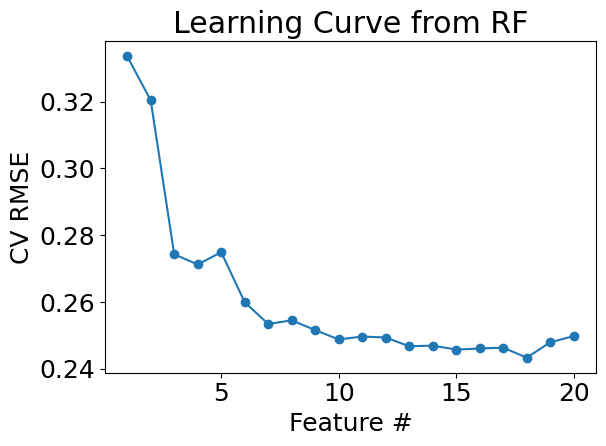

In [18]:
#df_lc.plot(kind = 'line',
#         x = 'train_sizes',
#         y = 'test_mean',
#         color = 'red')

# set the plot
xpl=df_lc_rf.loc[:,"train_sizes"]
ypl=df_lc_rf.loc[:,"test_mean"]
plt.plot(xpl,ypl, linestyle='-', marker='o')
plt.title('Learning Curve from RF')
plt.xlabel("Feature #")
plt.ylabel("CV RMSE")

# show the plot
plt.show()

# Feature reduction with SHAP.
Let's use the ShapFeatureSelector, which fits the data
using a random forest model but selects features based on the resulting SHAP scores.  We will keep the top 20 features.

In [19]:
model = SklearnModel(model='RandomForestRegressor')
selector = ShapFeatureSelector(model=model,
                               n_features_to_select=20)
X_SHAP = selector.evaluate(X=X, y=y, savepath='./resources/', make_new_dir=False)
print('Features selected with SHAP')
X_SHAP.head(5)

Features selected with SHAP


,SpecificHeatCapacity_composition_average,MeltingT_composition_average,HeatVaporization_composition_average,BCCvolume_padiff_composition_average,NdValence_composition_average,IonicRadii_composition_average,MendeleevNumber_composition_average,HeatCapacityMass_composition_average,IsFCC_composition_average,MiracleRadius_composition_average,HHIr_composition_average,FirstIonizationEnergy_composition_average,GSenergy_pa_composition_average,ThirdIonizationEnergy_composition_average,valence_composition_average,BCCmagmom_composition_average,ElectronAffinity_composition_average,ElasticModulus_composition_average,HeatFusion_composition_average,AtomicVolume_composition_average
0,0.235,1234.930,250.630,-0.1300,10.0,1.150,65.0,0.235,1.0,144.0,1400.0,7.576230,-2.765394,34.8300,2.0,0.000000,125.70,80.0,11.300,17.075648
1,0.328,1501.465,311.965,0.0325,8.5,0.900,61.5,0.328,0.5,134.5,2050.0,7.728620,-4.922891,34.1650,2.5,0.842019,97.85,144.0,13.750,14.035754
2,0.342,1707.465,295.065,-0.0750,7.5,0.885,57.0,0.342,0.5,137.0,2750.0,7.171370,-6.135555,32.8950,4.0,0.000000,94.85,169.5,16.150,14.584293
3,0.310,1296.350,275.565,-0.0600,10.0,0.940,64.5,0.310,1.0,135.0,1450.0,7.651305,-3.223024,35.8300,2.0,0.000000,122.00,102.0,12.450,14.452795
4,0.342,1522.965,300.065,-0.0650,8.0,0.850,60.0,0.342,0.5,134.5,1400.0,7.739315,-5.525439,32.7405,4.0,1.055331,74.85,145.5,12.555,14.426506


Now let's generate a feature learning curve with these features ranked by SHAP score.

In [20]:
learningcurve = LearningCurve()
learningcurve.evaluate(model=model,
                        X=X_SHAP,
                        y=y,
                        savepath='./resources/',
                        selector=selector,
                        make_new_dir=True,
                        make_plot=True)

The above saves everything in a directory with nice pictures, but it is helpful to pull in the data here to make our own plots.

In [21]:
# Open file with the learning curve vs. features and pull in data and make plot.
datafile_temp = learningcurve.splitdir + '/' + 'feature_learning_curve.xlsx'
print('Datafile I am uploading',datafile_temp)
df_lc_shap = pd.read_excel(datafile_temp)
df_lc_shap.head(5)

Datafile I am uploading ./resources/LearningCurve_10_16_11_19_42/feature_learning_curve.xlsx


,train_sizes,features selected,train_mean,train_std,test_mean,test_std
0,1,SpecificHeatCapacity_composition_average,0.190016,0.005288,0.326860,0.027541
1,2,MeltingT_composition_average,0.125354,0.006608,0.284164,0.029032
2,3,HeatVaporization_composition_average,0.122992,0.006515,0.284868,0.026097
3,4,BCCvolume_padiff_composition_average,0.117594,0.004071,0.270008,0.018227
4,5,MendeleevNumber_composition_average,0.110976,0.005747,0.244347,0.020334


Plot the learning curve.

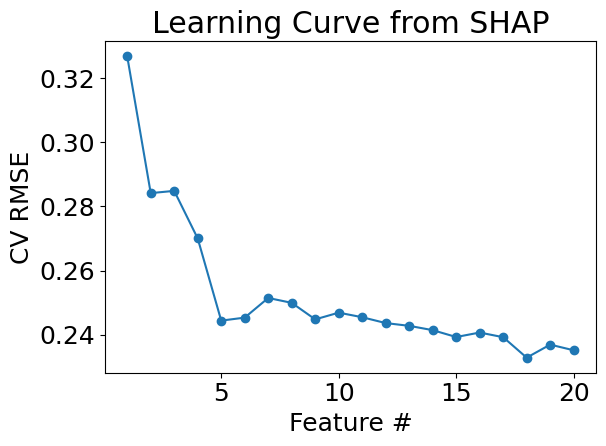

In [22]:
#df_lc.plot(kind = 'line',
#         x = 'train_sizes',
#         y = 'test_mean',
#         color = 'red')

# set the plot
xpl=df_lc_shap.loc[:,"train_sizes"]
ypl=df_lc_shap.loc[:,"test_mean"]
plt.plot(xpl,ypl,linestyle='-',marker='o')
plt.title('Learning Curve from SHAP')
plt.xlabel("Feature #")
plt.ylabel("CV RMSE")

# show the plot
plt.show()

Plot two learning curves together (both random forest + SHAP).

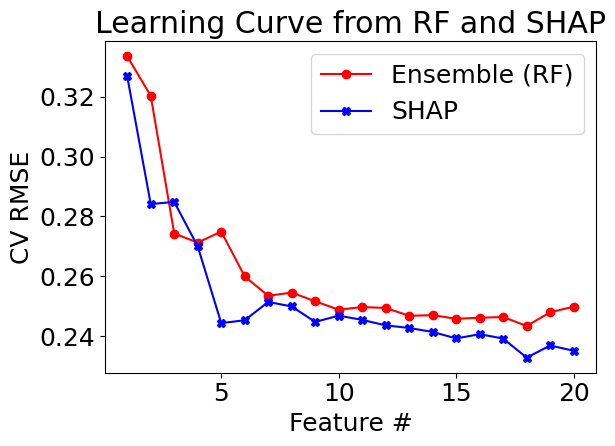

In [23]:
# set the plot
xpl=df_lc_shap.loc[:,"train_sizes"]
ypl_rf=df_lc_rf.loc[:,"test_mean"]
ypl_shap=df_lc_shap.loc[:,"test_mean"]
plt.plot(xpl,ypl_rf,linestyle='-',marker='o',color='r',label='Ensemble (RF)')
plt.plot(xpl,ypl_shap,linestyle='-',marker='X',color='b',label='SHAP')
plt.title('Learning Curve from RF and SHAP')
plt.xlabel("Feature #")
plt.ylabel("CV RMSE")
plt.legend()
# show the plot
plt.show()

# Feature reduction with Forward Selection.
Let's use basic forward selection which keeps each feature based on it lowering the CV score optimially. Here do the forward selection in the learning curve code since it is slow and we don't want to do it twice. I would set n_features_to_select to about 5.  It takes about 1min per feature for 80 total features and likely scales as (n_features_to_select)*(num total features).

In [24]:
model = SklearnModel(model='RandomForestRegressor')

# Fast linear model for testing (~10x faster than RF)
#model = SklearnModel(model='LinearRegression')

'''
selector = SklearnFeatureSelector(selector='SequentialFeatureSelector',
                                  estimator=model.model,
                                  n_features_to_select=30)
'''

selector = MASTMLFeatureSelector(model=model,
                                  n_features_to_select=5)

#X_fs = selector.evaluate(X=X, y=y, savepath=path, make_new_dir=False)



Now let's generate a feature learning curve with these features ranked by forward selection score.

In [25]:
learningcurve = LearningCurve()
'''
# for use with MASTMLFeatureSelector
learningcurve.evaluate(model=model,
                        X=X,
                        y=y,
                        savepath=path,
                        selector=selector,
                        make_new_dir=True,
                        make_plot=True)
'''
# For use with SklearnFeatureSelector
learningcurve.evaluate(model=model,
                        X=X,
                        y=y,
                        savepath='./resources/',
                        selector=selector,
                        make_new_dir=True,
                        make_plot=True)

The above saves everything in a directory with nice pictures if you use MASTML, but it is helpful to pull in the data here to make our own plots.

In [26]:
# Open file with the learning curve vs. features and pull in data and make plot.
datafile_temp = learningcurve.splitdir + '/' + 'feature_learning_curve.xlsx'
print('Datafile I am uploading',datafile_temp)
df_lc_fs = pd.read_excel(datafile_temp)
df_lc_fs.head(5)

Datafile I am uploading ./resources/LearningCurve_10_16_11_20_06/feature_learning_curve.xlsx


,train_sizes,features selected,train_mean,train_std,test_mean,test_std
0,1,AtomicNumber_composition_average,0.259918,0.006423,0.358927,0.017101
1,2,AtomicRadii_composition_average,0.135570,0.005391,0.316878,0.018317
2,3,ElectricalConductivity_composition_average,0.131607,0.004512,0.312872,0.023132
3,4,AtomicWeight_composition_average,0.129602,0.005457,0.307687,0.016321
4,5,Column_composition_average,0.117612,0.006332,0.275737,0.021666


Plot the learning curve.

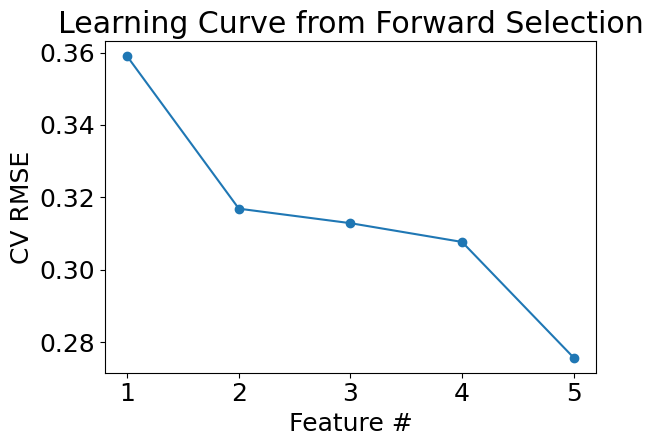

In [27]:
#df_lc.plot(kind = 'line',
#         x = 'train_sizes',
#         y = 'test_mean',
#         color = 'red')

# set the plot
xpl=df_lc_fs.loc[:,"train_sizes"]
ypl=df_lc_fs.loc[:,"test_mean"]
plt.plot(xpl,ypl,linestyle='-',marker='o')
plt.title('Learning Curve from Forward Selection')
plt.xlabel("Feature #")
plt.ylabel("CV RMSE")

# show the plot
plt.show()

Here are some convergence with features plots based on about 80 features. These should look similar, if not identical, in overlapping regions.  They do not look the same at first glance. But if you remove the last point of each plot it is much better.  I suspect the last point is some kind of special value we should ignore for now.

* 20 features (2023-10-11)

![image.png](
  
)
* 20 features (2023-10-11)

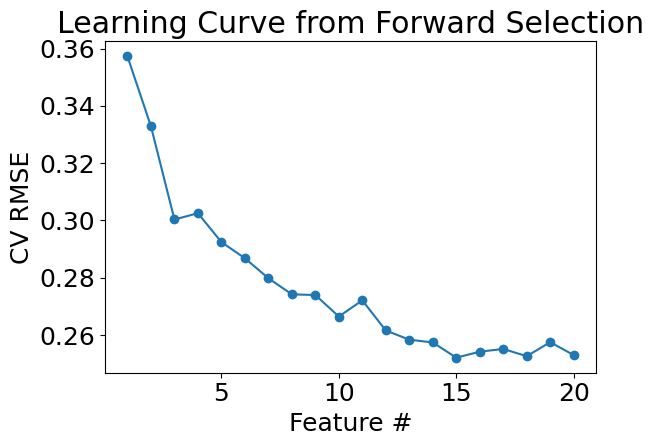

OLD (2022)
These seem different (not sure why) so ignore them for now.

30 features

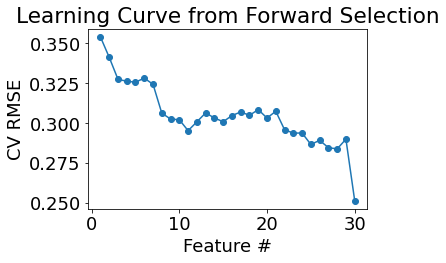

20 features

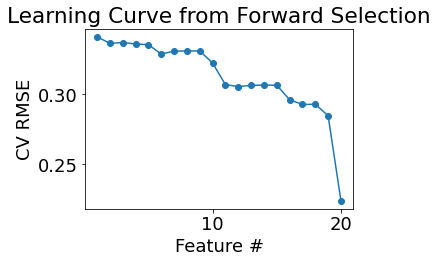

7 features

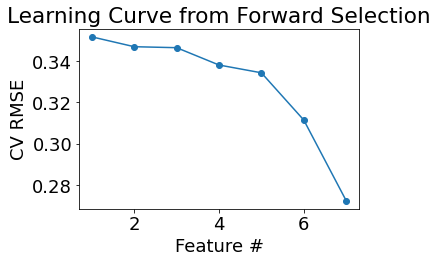


Plot the learning curves together (random forest, SHAP, and forward selection).

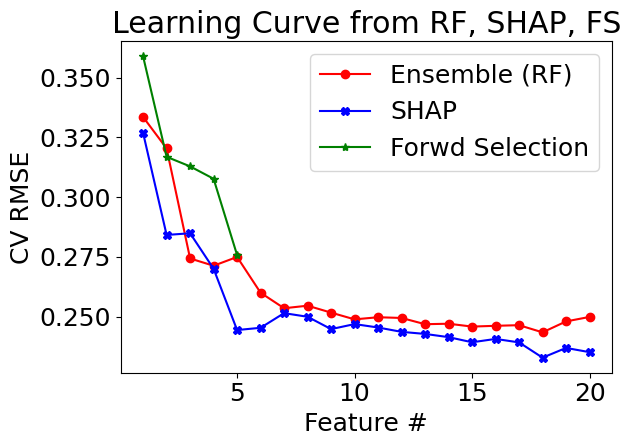

In [28]:
# set the plot
xpl_rf=df_lc_rf.loc[:,"train_sizes"]
xpl_shap=df_lc_shap.loc[:,"train_sizes"]
xpl_fs=df_lc_fs.loc[:,"train_sizes"]
ypl_rf=df_lc_rf.loc[:,"test_mean"]
ypl_shap=df_lc_shap.loc[:,"test_mean"]
ypl_fs=df_lc_fs.loc[:,"test_mean"]
plt.plot(xpl_rf,ypl_rf,linestyle='-',marker='o',color='r',label='Ensemble (RF)')
plt.plot(xpl_shap,ypl_shap,linestyle='-',marker='X',color='b',label='SHAP')
plt.plot(xpl_fs,ypl_fs,linestyle='-',marker='*',color='g',label='Forwd Selection')
plt.title('Learning Curve from RF, SHAP, FS')
plt.xlabel("Feature #")
plt.ylabel("CV RMSE")
plt.legend()
# show the plot
plt.show()

I generally found that forward selection was worse, e.g., see specific runs below. This suggests that the local minimum of greedy forward selection is not particularly good vs. the more globally optimal RF and SHAP feature rankings.

* 20 features in forward selection 2023-10-11

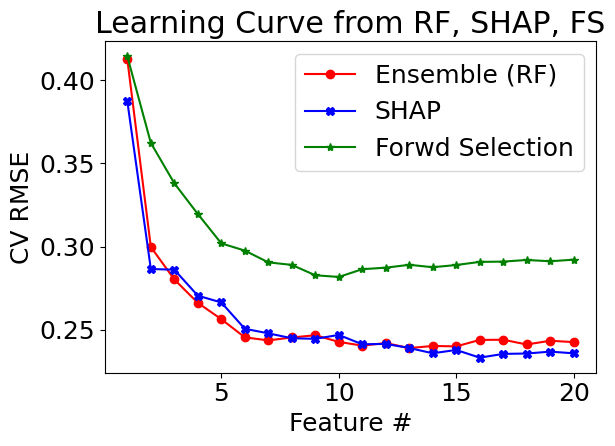

* OLD 2022
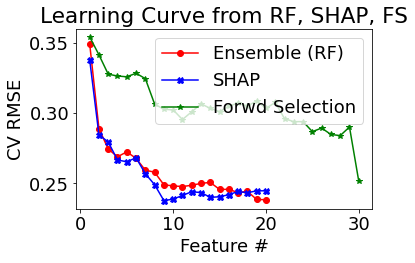

# Questions
Please do the following questions.  Just write the code here at the end of the notebook and turn in the notebook and output as pdf.

**Question 1:**  Explore the prediction of a GPR model using just the top 20 features as selected by Random Forest. This is an exact parallel to the section above that looked at the prediction of a GPR model with just 20 features from PCA. Make sure the scale the data first.  Make sure to learn scaling, feature selection on training data and then apply to test data to avoid data leakage. Make the train and test parity plots that match those made above for GPR with PCA.

**Question 1 Solution**

**Question 2:**  Now let's explore how well PCA selected features compare to random forest selected features. To make the comparison here please develop a forward selection model based on a random forest model using the first 20 principal components (PCs) of the feature vectors (use the short list of features above to get PCs). Note that this uses random forest to do the fitting, but gets features from PCA. Create the associated learning curve (CV RMSE vs. features) and plot along with data from the learning curve based on ranking of random forest selected features (from above). This shows that PCA does not seem to help us vs. random forest features. Note that forward selection is slow so best to test your code with just top ~3 PCAs to make sure it works and then run with all 20.

**Question 2 Solution**